# Tutorial 2: Feedforward neural networks in PyTorch

PSI 2022-2023

Machine Learning for Many-Body Physics

March 7, 2023

Code by Lauren Hayward, Juan Carrasquilla, and Mohamed Hibat Allah

## Create and plot the data set


Matplotlib is building the font cache; this may take a moment.


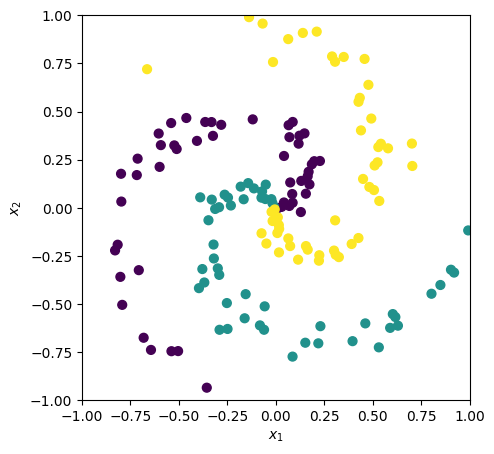

In [1]:
#from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

N = 50 # number of points per branch
K = 3  # number of branches

N_train = N*K # total number of points in the training set
x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
y_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)

mag_noise = 0.3  # controls how much noise gets added to the data
dTheta    = 4    # difference in theta in each branch

### Data generation: ###
for j in range(K):
  ix = range(N*j,N*(j+1))
  r  = np.linspace(0.01,1,N) # radius
  th = np.linspace(j*(2*np.pi)/K,j*(2*np.pi)/K + dTheta,N) + np.random.randn(N)*mag_noise # theta
  x_train[ix] = np.c_[r*np.cos(th), r*np.sin(th)]
  y_train[ix] = j

### Plot the data set: ###
fig = plt.figure(1, figsize=(5,5))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=40)#, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('spiral_data.pdf', bbox_inches="tight")
plt.show()

In [ ]:
#Run this cell if you want to save a pdf plot of the dataset:
#files.download('spiral_data.pdf')

## Define the network architecture and training hyperparameters

In [ ]:
%matplotlib inline
from IPython import display

import time
import torch

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.output_size)
        self.relu    = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        a1 = self.sigmoid(linear1_out)

        #Network output:
        aL = a1

        return aL

input_size = 2
output_size = K
model = FeedforwardNN(input_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

### One hot encoding ###
y_onehot = np.zeros((y_train.size, K))
y_onehot[np.arange(y_train.size),y_train] = 1
y_onehot = torch.tensor(y_onehot, dtype = torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Cost function: ###
cost_func = torch.nn.MSELoss()

N_epochs = 10000 # number of times to run gradient descent

## Training

In [ ]:
epoch_list    = []
cost_training = []
acc_training  = []

############ Function for plotting: ############
def updatePlot():

    ### Generate coordinates covering the whole plane: ###
    padding = 0.1
    spacing = 0.02
    x1_min, x1_max = x_train[:, 0].min() - padding, x_train[:, 0].max() + padding
    x2_min, x2_max = x_train[:, 1].min() - padding, x_train[:, 1].max() + padding
    x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, spacing),
                         np.arange(x2_min, x2_max, spacing))

    torch_input = torch.tensor(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype = torch.float)
    NN_output = model(torch_input)
    predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)

    ### Plot the classifier: ###
    plt.subplot(121)
    plt.contourf(x1_grid, x2_grid, predicted_class.reshape(x1_grid.shape), K, alpha=0.8)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=40)
    plt.xlim(x1_grid.min(), x1_grid.max())
    plt.ylim(x2_grid.min(), x2_grid.max())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')

    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, y_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters

    ### Update the plot and print results every 500 epochs: ###
    if epoch % 500 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == y_train)

        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)

        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        display.clear_output(wait=True)
        # time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

plt.savefig('spiral_results.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )

In [ ]:
#Run this cell if you want to save a pdf plot of the results:
#files.download('spiral_results.pdf')